In [32]:
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

warnings.filterwarnings('ignore')

# Set up plotting style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configure matplotlib for high-quality outputs
plt.rcParams.update({
    'figure.figsize': (12, 10),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

print("Libraries imported successfully!")

Libraries imported successfully!


In [33]:
@dataclass
class ExperimentConfig:
    """Configuration class for experiment parameters"""
    # File paths
    data_file: str = "cell_metrics.parquet"  # Using parquet for better performance
    
    # Analysis parameters
    epsilon: float = 0.1  # Minimum fluorescence threshold
    time_interval: float = 300  # Time interval in seconds (10 minutes)
    fluorescence_factor: float = 3  # Factor for fluorescence imaging frequency
    
    # Selection parameters (placeholders - customize as needed)
    selected_positions: List[int] = None
    time_range: Tuple[int, int] = None
    
    # Channel mappings
    channel_colors: Dict[str, str] = None
    channel_names: Dict[str, str] = None
    
    def __post_init__(self):
        if self.selected_positions is None:
            self.selected_positions = [0, 1, 2, 3]  # Default positions
        
        if self.time_range is None:
            self.time_range = (0, 5000)  # Default time range
        
        if self.channel_colors is None:
            self.channel_colors = {
                "mcherry": "#FF4444",  # Red
                "yfp": "#FFB347",       # Orange/Yellow
                "1": "#FF4444",  # Red
                "2": "#FFB347"       # Orange/Yellow
            }
        
        if self.channel_names is None:
            self.channel_names = {
                "mcherry": "mCherry",
                "yfp": "YFP",
                "1": "mCherry",
                "2": "YFP"
            }

# Initialize configuration
config = ExperimentConfig()
print(f"Configuration initialized:")
print(f"  - Selected positions: {config.selected_positions}")
print(f"  - Time range: {config.time_range}")
print(f"  - Epsilon threshold: {config.epsilon}")

Configuration initialized:
  - Selected positions: [0, 1, 2, 3]
  - Time range: (0, 5000)
  - Epsilon threshold: 0.1


In [40]:
def load_and_preprocess_data(filepath: str, config: ExperimentConfig) -> pl.DataFrame:
    """
    Load and preprocess fluorescence data with filtering and scaling
    """
    try:
        # Load data
        if filepath.endswith('.parquet'):
            df = pl.read_parquet(filepath)
        else:
            df = pl.read_csv(filepath)
        
        print(f"Data loaded successfully. Shape: {df.shape}")
        print(f"Columns: {df.columns}")

        filtered_df = df
        
        # Apply filters
        filtered_df = df.filter(
            (pl.col("position").is_in(config.selected_positions)) &
            (pl.col("time") >= config.time_range[0]) &
            (pl.col("time") <= config.time_range[1])
        )
        
        # # Remove low fluorescence values based on epsilon
        fluorescence_cols = [col for col in df.columns if col.startswith("fluo_")]
        
        for col in fluorescence_cols:
            filtered_df = filtered_df.filter(pl.col(col) > config.epsilon)
        
        # Scale time to hours
        time_scaling_factor = config.time_interval * config.fluorescence_factor / 3600
        filtered_df = filtered_df.with_columns(
            (pl.col("time") * time_scaling_factor).alias("time_hours")
        )
        
        print(f"After filtering - Shape: {filtered_df.shape}")
        return filtered_df
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return pl.DataFrame()

# Load data (create sample data if file doesn't exist)
def create_sample_data(config: ExperimentConfig) -> pl.DataFrame:
    """Create sample data for demonstration purposes"""
    np.random.seed(42)
    
    n_timepoints = config.time_range[1] - config.time_range[0] + 1
    n_positions = len(config.selected_positions)
    n_cells_per_position = 50
    
    data = []
    
    for t in range(config.time_range[0], config.time_range[1] + 1):
        for pos in config.selected_positions:
            for cell_id in range(n_cells_per_position):
                # Simulate fluorescence with some biological variation
                base_mcherry = 100 + 50 * np.sin(t * 0.1) + np.random.normal(0, 20)
                base_yfp = 80 + 30 * np.cos(t * 0.1) + np.random.normal(0, 15)
                
                data.append({
                    "time": t,
                    "position": pos,
                    "cell_id": f"{pos}_{cell_id}",
                    "fluo_mcherry": max(config.epsilon + 0.1, base_mcherry),
                    "fluo_yfp": max(config.epsilon + 0.1, base_yfp)
                })
    
    return pl.DataFrame(data)

# NOTE: change
# csv = "/Volumes/legazpi/22 OliveiraLab/22.20 Lauren Dataset/1_9_lauren_replicate_2/analysis_save/metrics_data.csv"
csv = "/Volumes/legazpi/22 OliveiraLab/22.20 Lauren Dataset/1-9-omnipose-12-jun/metrics_data.csv"

# Try to load real data, fallback to sample data
try:
    df = load_and_preprocess_data(csv, config)
    if df.is_empty():
        raise FileNotFoundError("Data file not found or empty")
except:
    print("Creating sample data for demonstration...")
    df = create_sample_data(config)
    df = load_and_preprocess_data("", config)  # Apply preprocessing to sample data

print(f"Final dataset ready with {df.shape[0]} rows and {df.shape[1]} columns")


Data loaded successfully. Shape: (7151190, 30)
Columns: ['position', 'time', 'cell_id', 'channel', 'area', 'perimeter', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'centroid_y', 'centroid_x', 'aspect_ratio', 'circularity', 'solidity', 'equivalent_diameter', 'orientation', 'morphology_class', 'y1', 'x1', 'y2', 'x2', 'mean_intensity', 'max_intensity', 'min_intensity', 'std_intensity', 'integrated_intensity', 'background_intensity', 'normalized_intensity', 'fluo_1', 'fluo_2']
After filtering - Shape: (219277, 31)
Final dataset ready with 219277 rows and 31 columns


In [41]:
def calculate_population_statistics(df: pl.DataFrame, 
                                  fluorescence_col: str) -> pl.DataFrame:
    """
    Calculate mean and standard deviation for each timepoint
    """
    stats = (
        df.group_by("time")
        .agg([
            pl.col(fluorescence_col).mean().alias("mean_intensity"),
            pl.col(fluorescence_col).std().alias("std_intensity"),
            pl.col(fluorescence_col).count().alias("cell_count")
        ])
        .sort("time")
    )
    
    # Add scaled time
    time_scaling_factor = config.time_interval * config.fluorescence_factor / 3600
    stats = stats.with_columns(
        (pl.col("time") * time_scaling_factor).alias("time_hours")
    )
    
    return stats

def prepare_plotting_data(df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
    """
    Prepare data for all fluorescence channels
    """
    plotting_data = {}
    
    fluorescence_cols = [col for col in df.columns if col.startswith("fluo_")]
    
    for col in fluorescence_cols:
        channel_name = col.replace("fluo_", "")
        plotting_data[channel_name] = calculate_population_statistics(df, col)
    
    return plotting_data

# Calculate statistics for plotting
plotting_data = prepare_plotting_data(df)

print("Statistics calculated for channels:")
for channel, data in plotting_data.items():
    print(f"  - {channel}: {data.shape[0]} timepoints")


Statistics calculated for channels:
  - 1: 142 timepoints
  - 2: 142 timepoints


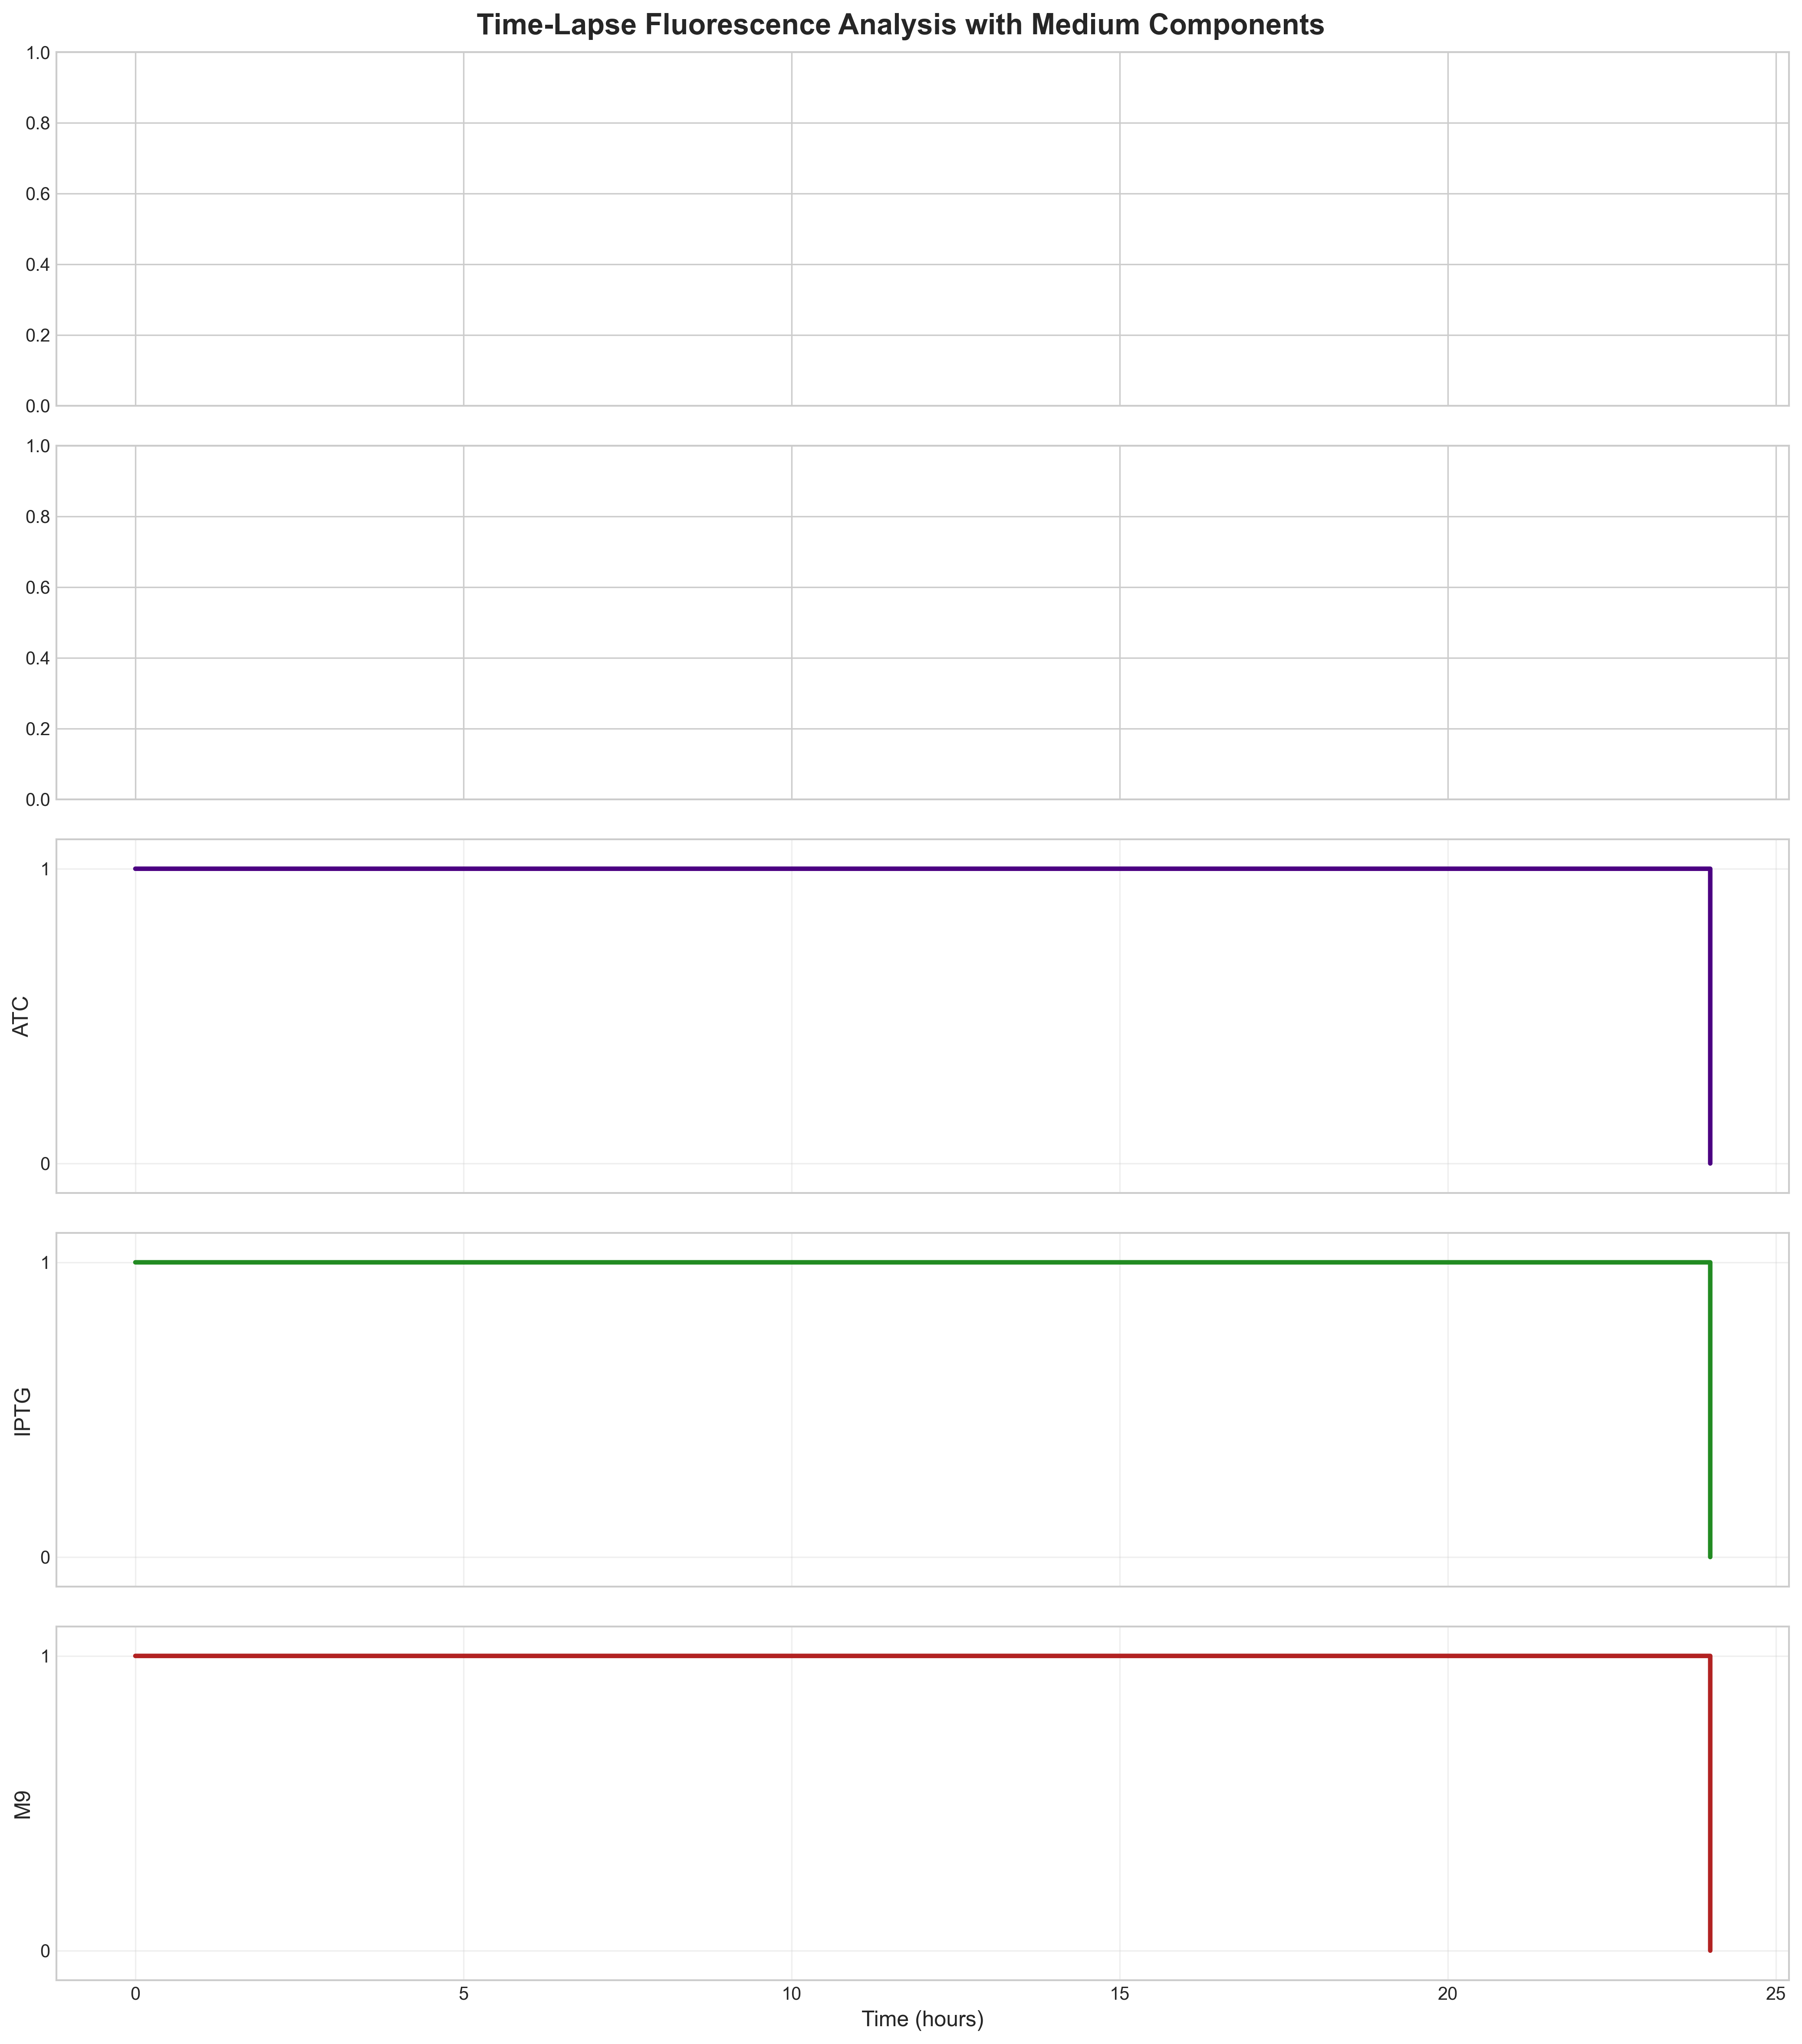

In [47]:
def create_medium_step_functions(time_hours: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Create step functions for experimental medium components (ATC, IPTG, M9)
    Returns dictionary with component keys and binary activation arrays
    """
    # Define component activation intervals (customize these time ranges)
    component_intervals = {
        'atc': [(0, 6), (6, 12), (12, 24)],  # Example: ATC pulses
        'iptg': [(0, 8), (8, 18), (18, 24)],  # IPTG induction phases
        'm9': [(0, 10), (10, 24)]            # M9 medium transitions
    }
    
    step_functions = {}
    for component, intervals in component_intervals.items():
        activation = np.zeros_like(time_hours)
        for start, end in intervals:
            activation[(time_hours >= start) & (time_hours < end)] = 1
        step_functions[component] = activation
    
    return step_functions

def create_comprehensive_fluorescence_plot(plotting_data: Dict[str, pl.DataFrame], 
                                         medium_steps: Dict[str, np.ndarray],
                                         config: ExperimentConfig,
                                         time_hours: np.ndarray,
                                         save_path: Optional[str] = None) -> plt.Figure:
    """
    Create 4x1 subplot with fluorescence signals and medium step functions
    """
    fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)
    fig.suptitle('Time-Lapse Fluorescence Analysis with Medium Components', 
                fontsize=16, fontweight='bold', y=0.98)
    
    # Plot fluorescence channels (original code)
    channels = ['mcherry', 'yfp']
    for i, channel in enumerate(channels):
        if channel in plotting_data:
            data = plotting_data[channel]
            times = data["time_hours"].to_numpy()
            means = data["mean_intensity"].to_numpy()
            stds = data["std_intensity"].to_numpy()
            
            ax = axes[i]
            color = config.channel_colors.get(channel, '#666666')
            channel_name = config.channel_names.get(channel, channel.title())
            
            ax.plot(times, means, color=color, linewidth=2.5, 
                   marker='o', markersize=4, alpha=0.8)
            ax.fill_between(times, means - stds, means + stds, 
                           color=color, alpha=0.2)
            ax.set_ylabel(f'{channel_name}\nFluorescence (RPU)', fontsize=12)
            ax.grid(True, alpha=0.3)

    # Plot medium step functions
    component_colors = {'atc': '#4B0082', 'iptg': '#228B22', 'm9': '#B22222'}
    for idx, (component, values) in enumerate(medium_steps.items(), start=2):
        ax = axes[idx]
        ax.step(time_hours, values, where='post', 
               color=component_colors.get(component, '#666666'), 
               linewidth=2.5)
        ax.set_ylabel(component.upper(), fontsize=12)
        ax.set_yticks([0, 1])
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time (hours)', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig

# Usage Example
time_hours = np.linspace(0, 24, 1000)  # Use actual experimental time points
medium_steps = create_medium_step_functions(time_hours)
fig = create_comprehensive_fluorescence_plot(plotting_data, medium_steps, config, time_hours)
plt.show()


Plot saved to: fluorescence_analysis.png


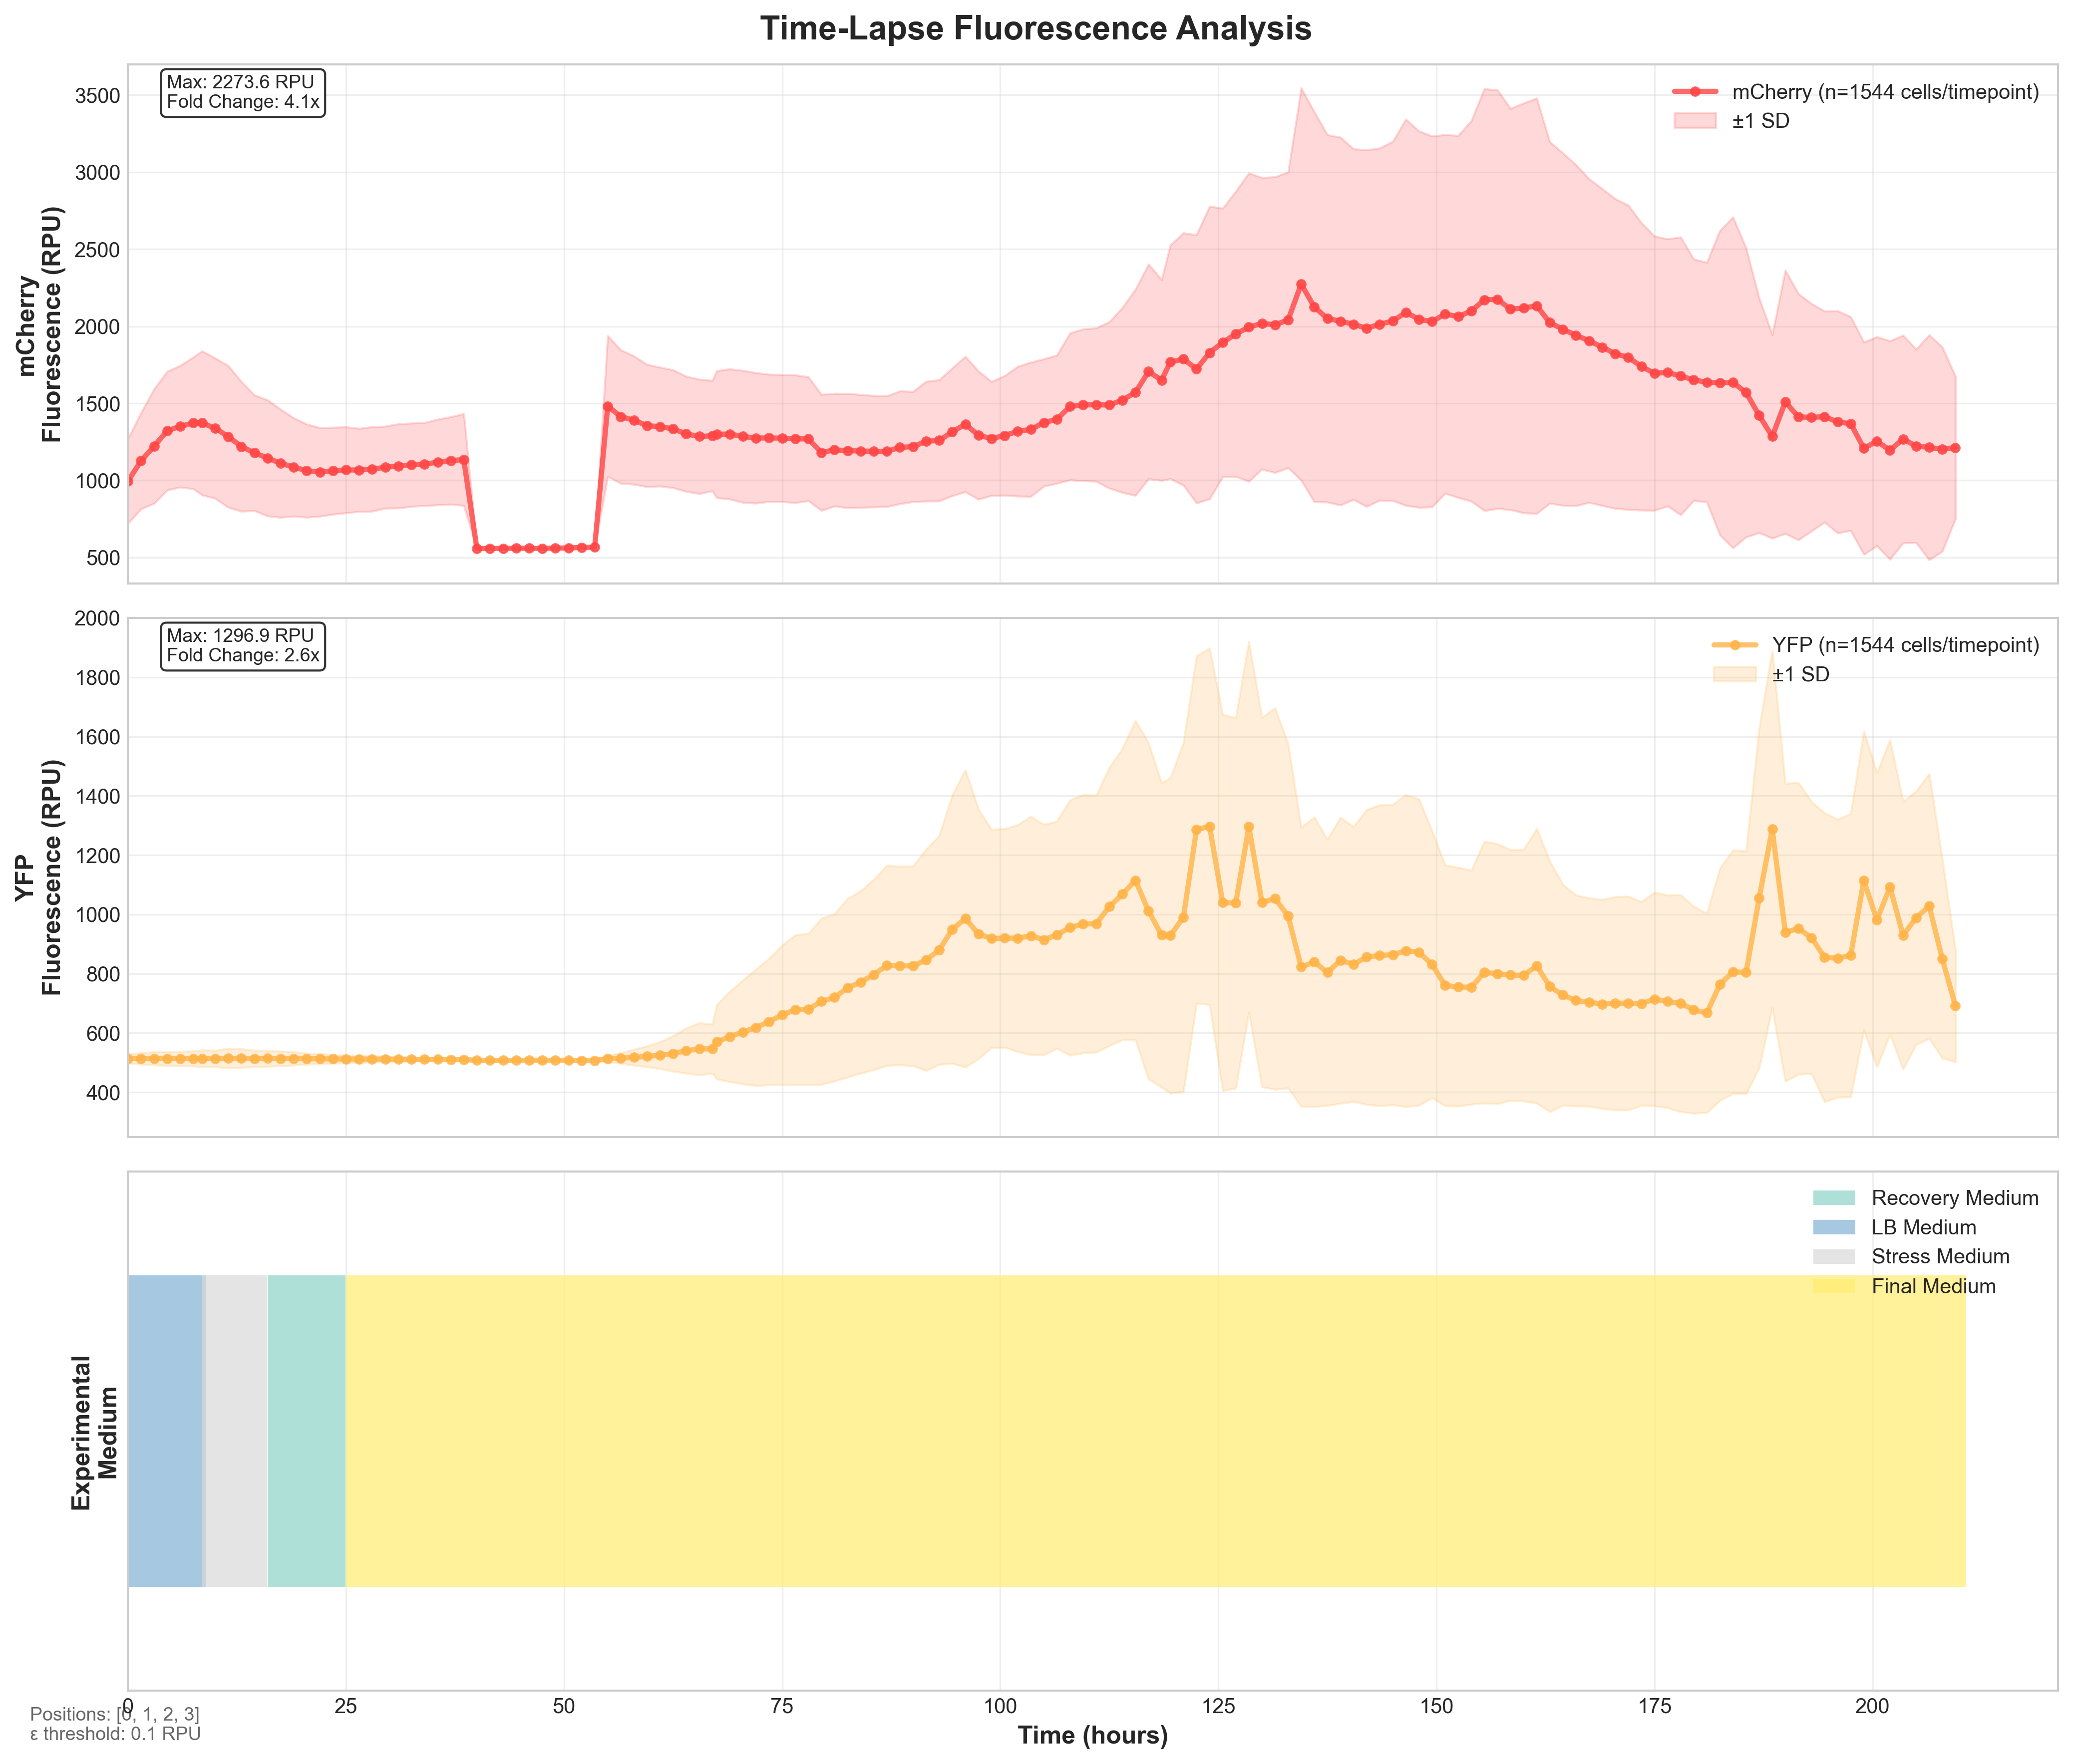

In [43]:
def create_comprehensive_fluorescence_plot(plotting_data: Dict[str, pl.DataFrame], 
                                         medium_df: pl.DataFrame,
                                         config: ExperimentConfig,
                                         save_path: Optional[str] = None) -> plt.Figure:
    """
    Create publication-quality 3x1 subplot with shared time axis
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    fig.suptitle('Time-Lapse Fluorescence Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    # Channel order for plotting
    # channels = ['mcherry', 'yfp']
    channels = ['1', '2']
    
    # Plot fluorescence channels
    for i, channel in enumerate(channels):
        if channel in plotting_data:
            data = plotting_data[channel]
            times = data["time_hours"].to_numpy()
            means = data["mean_intensity"].to_numpy()
            stds = data["std_intensity"].to_numpy()
            
            ax = axes[i]
            color = config.channel_colors.get(channel, '#666666')
            channel_name = config.channel_names.get(channel, channel.title())
            
            # Main line plot
            line = ax.plot(times, means, color=color, linewidth=2.5, 
                          label=f'{channel_name} (n={data["cell_count"].mean():.0f} cells/timepoint)',
                          marker='o', markersize=4, alpha=0.8)
            
            # Error bands
            ax.fill_between(times, means - stds, means + stds, 
                           color=color, alpha=0.2, label='±1 SD')
            
            # Styling
            ax.set_ylabel(f'{channel_name}\nFluorescence (RPU)', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', framealpha=0.9)
            
            # Add statistics text box
            max_intensity = means.max()
            fold_change = means.max() / means.min() if means.min() > 0 else np.inf
            stats_text = f'Max: {max_intensity:.1f} RPU\nFold Change: {fold_change:.1f}x'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)
    
    # Medium timeline plot
    ax3 = axes[2]
    
    if not medium_df.is_empty():
        # Create medium blocks
        unique_media = medium_df["medium"].unique().to_list()
        medium_colors = plt.cm.Set3(np.linspace(0, 1, len(unique_media)))
        
        for i, medium in enumerate(unique_media):
            medium_times = medium_df.filter(pl.col("medium") == medium)["time"].to_numpy()
            if len(medium_times) > 0:
                ax3.barh(0, len(medium_times) * np.diff(times).mean() if len(times) > 1 else 1, 
                        left=medium_times[0], height=0.6, 
                        color=medium_colors[i], alpha=0.7, label=medium)
        
        ax3.set_ylabel('Experimental\nMedium', fontsize=12, fontweight='bold')
        ax3.set_ylim(-0.5, 0.5)
        ax3.set_yticks([])
        ax3.legend(loc='upper right', framealpha=0.9)
        ax3.grid(True, alpha=0.3)
    
    # Shared x-axis formatting
    axes[-1].set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
    
    # Add experimental info
    info_text = f'Positions: {config.selected_positions}\nε threshold: {config.epsilon} RPU'
    fig.text(0.02, 0.02, info_text, fontsize=9, alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig

# Create the comprehensive plot
fig = create_comprehensive_fluorescence_plot(plotting_data, medium_df, config, 
                                           save_path="fluorescence_analysis.png")
plt.show()


In [44]:
def export_analysis_results(plotting_data: Dict[str, pl.DataFrame], 
                          medium_df: pl.DataFrame,
                          config: ExperimentConfig,
                          output_dir: str = "analysis_results") -> None:
    """
    Export all analysis results to files
    """
    from pathlib import Path
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Export fluorescence statistics
    for channel, data in plotting_data.items():
        filename = output_path / f"{channel}_statistics.csv"
        data.write_csv(str(filename))
        print(f"Exported {channel} statistics to: {filename}")
    
    # Export medium timeline
    if not medium_df.is_empty():
        medium_file = output_path / "medium_timeline.csv"
        medium_df.write_csv(str(medium_file))
        print(f"Exported medium timeline to: {medium_file}")
    
    # Export configuration
    import json
    config_dict = {
        'selected_positions': config.selected_positions,
        'time_range': config.time_range,
        'epsilon': config.epsilon,
        'time_interval': config.time_interval,
        'fluorescence_factor': config.fluorescence_factor
    }
    
    config_file = output_path / "analysis_config.json"
    with open(config_file, 'w') as f:
        json.dump(config_dict, f, indent=2)
    print(f"Exported configuration to: {config_file}")

def print_analysis_summary(plotting_data: Dict[str, pl.DataFrame]) -> None:
    """
    Print comprehensive analysis summary
    """
    print("\n" + "="*60)
    print("FLUORESCENCE ANALYSIS SUMMARY")
    print("="*60)
    
    for channel, data in plotting_data.items():
        channel_name = config.channel_names.get(channel, channel.title())
        means = data["mean_intensity"].to_numpy()
        times = data["time_hours"].to_numpy()
        
        print(f"\n{channel_name} Channel:")
        print(f"  • Duration: {times.min():.1f} - {times.max():.1f} hours")
        print(f"  • Peak intensity: {means.max():.2f} RPU at {times[np.argmax(means)]:.1f}h")
        print(f"  • Baseline intensity: {means.min():.2f} RPU")
        print(f"  • Fold change: {means.max()/means.min():.2f}x")
        print(f"  • Average cells per timepoint: {data['cell_count'].mean():.0f}")

# Export results and print summary
export_analysis_results(plotting_data, medium_df, config)
print_analysis_summary(plotting_data)


Exported 1 statistics to: analysis_results/1_statistics.csv
Exported 2 statistics to: analysis_results/2_statistics.csv
Exported medium timeline to: analysis_results/medium_timeline.csv
Exported configuration to: analysis_results/analysis_config.json

FLUORESCENCE ANALYSIS SUMMARY

mCherry Channel:
  • Duration: 0.0 - 209.5 hours
  • Peak intensity: 2273.56 RPU at 134.5h
  • Baseline intensity: 558.29 RPU
  • Fold change: 4.07x
  • Average cells per timepoint: 1544

YFP Channel:
  • Duration: 0.0 - 209.5 hours
  • Peak intensity: 1296.92 RPU at 124.0h
  • Baseline intensity: 507.08 RPU
  • Fold change: 2.56x
  • Average cells per timepoint: 1544


In [45]:
# Advanced configuration for different experiments
def update_experiment_config(**kwargs):
    """Update configuration parameters dynamically"""
    global config
    for key, value in kwargs.items():
        if hasattr(config, key):
            setattr(config, key, value)
            print(f"Updated {key}: {value}")
        else:
            print(f"Warning: {key} is not a valid configuration parameter")

# Example customizations (uncomment and modify as needed):

# # Change selected positions
# update_experiment_config(selected_positions=[0, 2, 4])

# # Change time range
# update_experiment_config(time_range=(10, 40))

# # Change epsilon threshold
# update_experiment_config(epsilon=0.5)

# # Rerun analysis with new parameters
# if 'df' in locals():
#     df_updated = load_and_preprocess_data(config.data_file, config)
#     plotting_data_updated = prepare_plotting_data(df_updated)
#     fig_updated = create_comprehensive_fluorescence_plot(plotting_data_updated, medium_df, config)
#     plt.show()

print("Configuration update functions ready!")
print(f"Current config: positions={config.selected_positions}, time_range={config.time_range}, ε={config.epsilon}")


Configuration update functions ready!
Current config: positions=[0, 1, 2, 3], time_range=(0, 5000), ε=0.1
